# Effect of random padding re-generation


## Setup

We derive ``DebugTest`` below from  (tickets/DM-30125 ip_diffim branch) ``test_imageDifference.py:ImageDifferenceTestZogy`` test class to update some of its methods for the test run. Metric1 is defined in ``ImageDifferenceTestBase.diffimMetric1()``. ``DebugTest.getMetric1Cutouts()`` is derived from ``ImageDifferenceTestBase.diffimMetric1()``. ``DebugTest.repeatZogy()`` is derived from ``ImageDifferenceTestZogy.testSimReverseZogy()``.


This test uses the branch `u/gkovacs/DM-30281_no_randomstate` modified branch of zogy, where the random number generator is not set to a deterministic state. We run the subtraction of the _same two test images, in the same order_ to test the effect of the changing random padding around the images.
```diff
--- a/python/lsst/ip/diffim/zogy.py                                                                                  
+++ b/python/lsst/ip/diffim/zogy.py                                                                                   
@@ -744,9 +744,10 @@ class ZogyTask(pipeBase.Task):                                                                   
         else:                                                                                                         
             self.subExpVar2 = self.fullExpVar2                                                                       
         # Initialize random number generator to a deterministic state                                                 
-        self.rng = np.random.default_rng(seed=np.array([self.subExpVar1]).view(int))                                
+        # self.rng = np.random.default_rng(seed=np.array([self.subExpVar1]).view(int))                              
+        self.rng = np.random.default_rng()
```

## Symptoms

Up to ~10-20% change in metric value if zogy is re-run w/ inputs swapped. As such the test fails. (The original operation of ``ImageDifferenceTestZogy.testSimReverseZogy()``.)

## Notes on tickets/DM-30125 ImageDifferenceTestZogy

* Metric X,Y coordinate was swapped. If measured at the source position the change down from to 1-2 pixels.
* Metric negative/positive terminology is swapped.

## Test results
* The residual has some background. Perhaps this simulated image was created this way, I did not check in details.
* Each pixel sign flip is duplicated in the metric, i.e. 10% change in metric value, means 5% of pixels have changed signs
* The regeneration of padding causes a small, but oscillating difference in the repeated zogy task. With these noise values up to order of ~0.1 in pixel value.



In [1]:
%matplotlib notebook
from lsst.pipe.base import Struct
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [2]:
# It seems that test files are not importable as modules in general - insert them directly here
%run -b -i "/ssd/gkovacs/devel/active/DM-30281_ip_diffim_notebook/tests/test_imageDifference.py"

In [3]:
# Copy-paste code from ImageDifferenceTestZogy and ImageDifferenceTestBase
class DebugTest(ImageDifferenceTestZogy):
    def getMetric1Cutouts(self, residual, sourceCat, radius=2):
        """Calculate Metric1 and return the image cutouts used for the calculation.
        
        Parameters
        ----------
        residual : `lsst.afw.image.Exposure`
            Zogy diffExp result.
            
        sourceCat : `lsst.afw.Table.SourceTable`
            Catalog of generated sources selected by `ImagePsfMatchTask.getSelectSources()`.
        
        radius : `int`
            Cutout size in each direction from the centroid pixel position. (Square cutout.)
            
        
        Returns
        -------
        Tuple of
            - ``metric`` : `float`
                Metric value.
            - ``L`` : `list` of `lsst.afw.image.Image`
                Image cutouts used for the metric calculation.
        """
        nNeg = 0
        nPos = 0
        L = []
        for src in sourceCat:
            srcX = int(src.getX()) - residual.getBBox().getBeginX()
            srcY = int(src.getY()) - residual.getBBox().getBeginY()
#             srcRes = residual.image.array[srcX - radius: srcX + radius + 1, srcY - radius: srcY + radius + 1]
            srcRes = residual.image.array[srcY - radius: srcY + radius + 1, srcX - radius: srcX + radius + 1]
            L.append(srcRes)
            # print(f"Shape of srcRes: {srcRes.shape}")
            nNeg += np.sum(srcRes > 0)
            nPos += np.sum(srcRes < 0)
        print(f"Number of finite pixels: {np.sum(np.isfinite(residual.image.array))}")
        print(f"nPos: {nPos}, nNeg: {nNeg}")
        print(f"Pixels used in the metric: {nPos + nNeg}")

        if (nPos + nNeg) == 0:
            metric = 0.
        else:
            metric = (nPos - nNeg)/(nPos + nNeg)
        return metric, L
    
    def repeatZogy(self):
        """Repeat same images, same order zogy subtraction to see the effect of random padding difference.
        
        Commented out code marks the original test case ``testSimReverseZogy()``.
        """
        nIter = 1
        refPsf = 2.
        sciPsfBase = 2.
        sciNoise = 5.
        refNoise = 1.5
        seed = 18
        rng = np.random.RandomState(seed)
        zogyConfig = ZogyConfig()
        sciPsf = sciPsfBase + rng.random()*2.
        s = 0
        ref, _ = self.makeTestImages(seed=seed + s, nSrc=20, psfSize=refPsf,
                                     noiseLevel=refNoise, fluxLevel=500)
        sci, src = self.makeTestImages(seed=seed + s, nSrc=20, psfSize=sciPsf,
                                       noiseLevel=sciNoise, fluxLevel=500)
        # The diffim tasks can modify the images, so make a deep copy to make sure they are independent
        sci2 = sci.clone()
        ref2 = ref.clone()

        # Check the metric cutouts on the generated images
        _, cutsSCI = self.getMetric1Cutouts(sci, src)
        _, cutsREF = self.getMetric1Cutouts(ref, src)
        # Run the same test 2x, the only difference will be in the random number generator state
        res = self.wrapZogyDiffim(zogyConfig, ref, sci)
        resR = self.wrapZogyDiffim(zogyConfig, ref2, sci2)
        # resR = self.wrapZogyDiffim(zogyConfig, sci2, ref2)
        # The stack code measures the metric at the wrong position
#         metric = self.diffimMetric1(res, src)
        print("======")
        metric, mL = self.getMetric1Cutouts(res, src)
#         metricR = self.diffimMetric1(resR, src)
        metricR, mRL = self.getMetric1Cutouts(resR, src)
        
        return Struct(metric=metric, metricR=metricR, cuts=mL, cutsR=mRL, cutsSCI=cutsSCI, cutsREF=cutsREF,
                      src=src, sci=sci, ref=ref, res=res, resR=resR)

In [4]:
test = DebugTest()
test.setUpClass()
test.setUp()

In [5]:
R = test.repeatZogy()

Number of finite pixels: 65000
nPos: 0, nNeg: 275
Pixels used in the metric: 275
Number of finite pixels: 65000
nPos: 0, nNeg: 275
Pixels used in the metric: 275
Number of finite pixels: 65000
nPos: 55, nNeg: 220
Pixels used in the metric: 275
Number of finite pixels: 65000
nPos: 54, nNeg: 221
Pixels used in the metric: 275


<IPython.core.display.Javascript object>


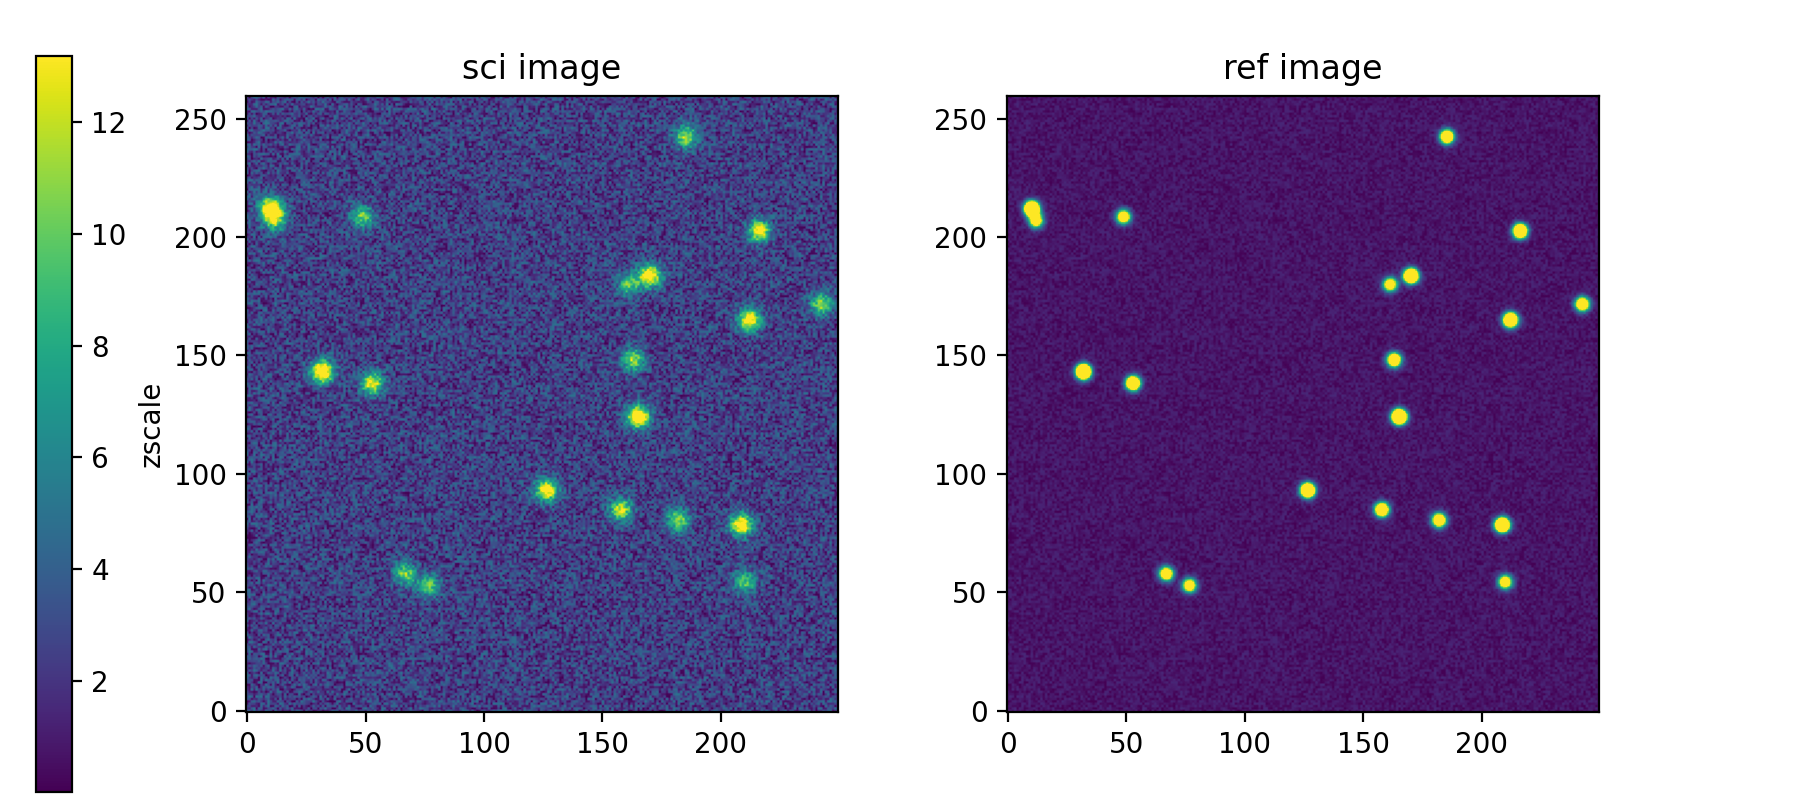

In [6]:
zscaler = ZScaleInterval()
vmin, vmax = zscaler.get_limits(R.sci.image.array)

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
cb = ax.imshow(R.sci.image.array, origin='lower', vmin=vmin, vmax=vmax)
ax.set_title("sci image")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(R.ref.image.array, origin='lower', vmin=vmin, vmax=vmax)
ax.set_title("ref image")

ax = fig.add_axes((0.02,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax, label='zscale')

<IPython.core.display.Javascript object>


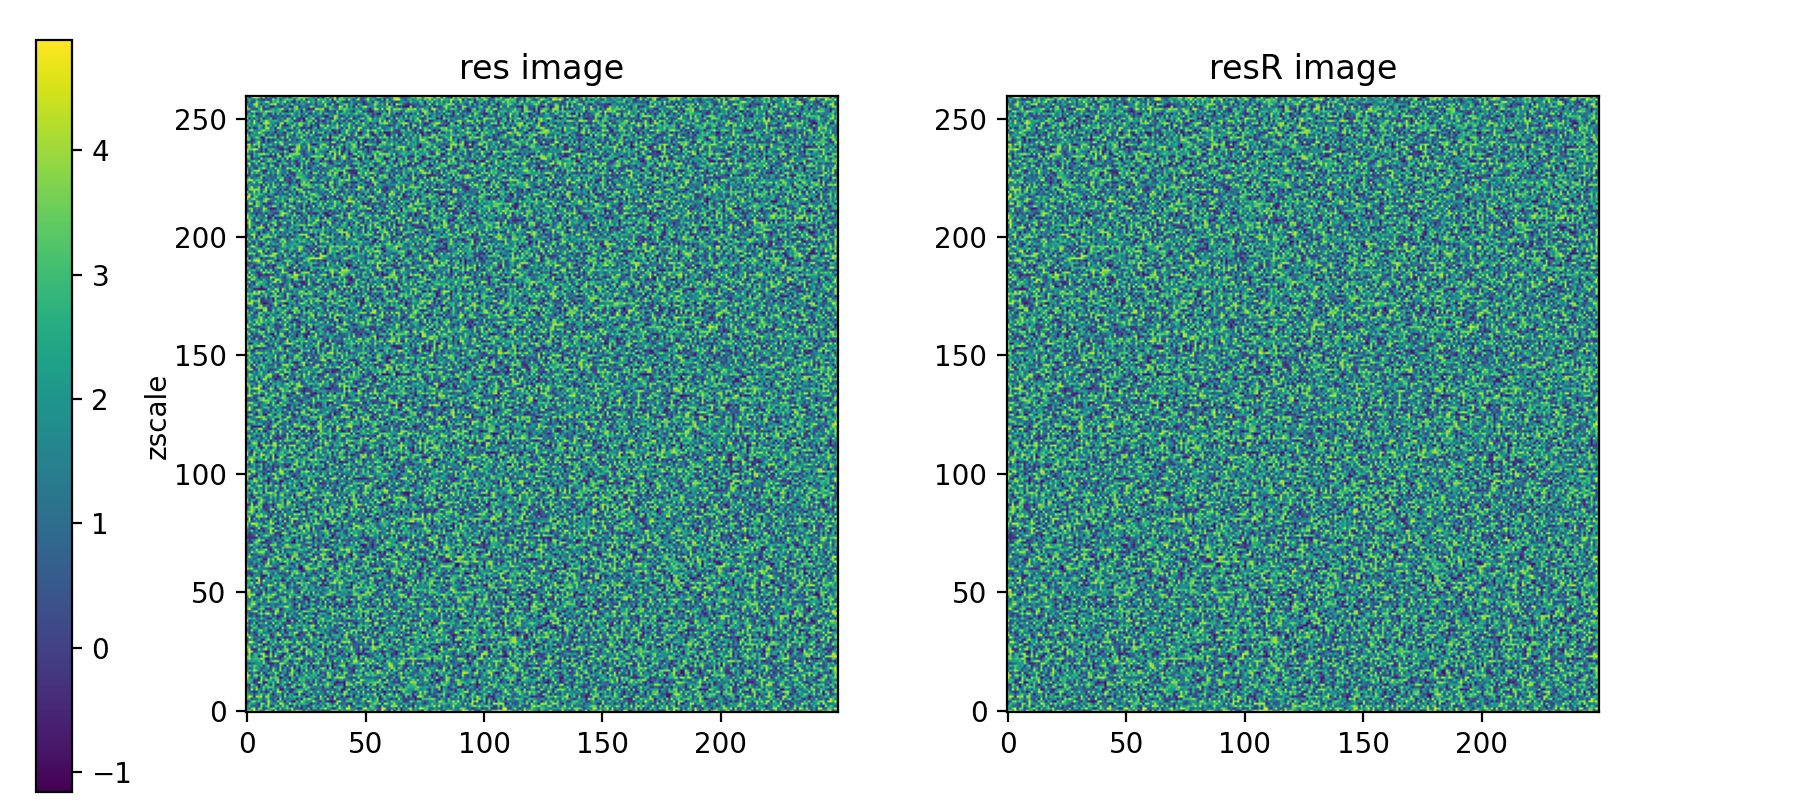

res median: 1.76 resR median:1.76


In [7]:
zscaler = ZScaleInterval()
vmin, vmax = zscaler.get_limits(R.res.image.array)

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
cb = ax.imshow(R.res.image.array, origin='lower', vmin=vmin, vmax=vmax)
ax.set_title("res image")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(R.resR.image.array, origin='lower', vmin=vmin, vmax=vmax)
ax.set_title("resR image")

ax = fig.add_axes((0.02,0.01,0.02,0.94))
fig.colorbar(cb, cax=ax, label='zscale')
print(f"res median: {np.median(R.res.image.array):.2f} resR median:{np.median(R.resR.image.array):.2f}")

<IPython.core.display.Javascript object>


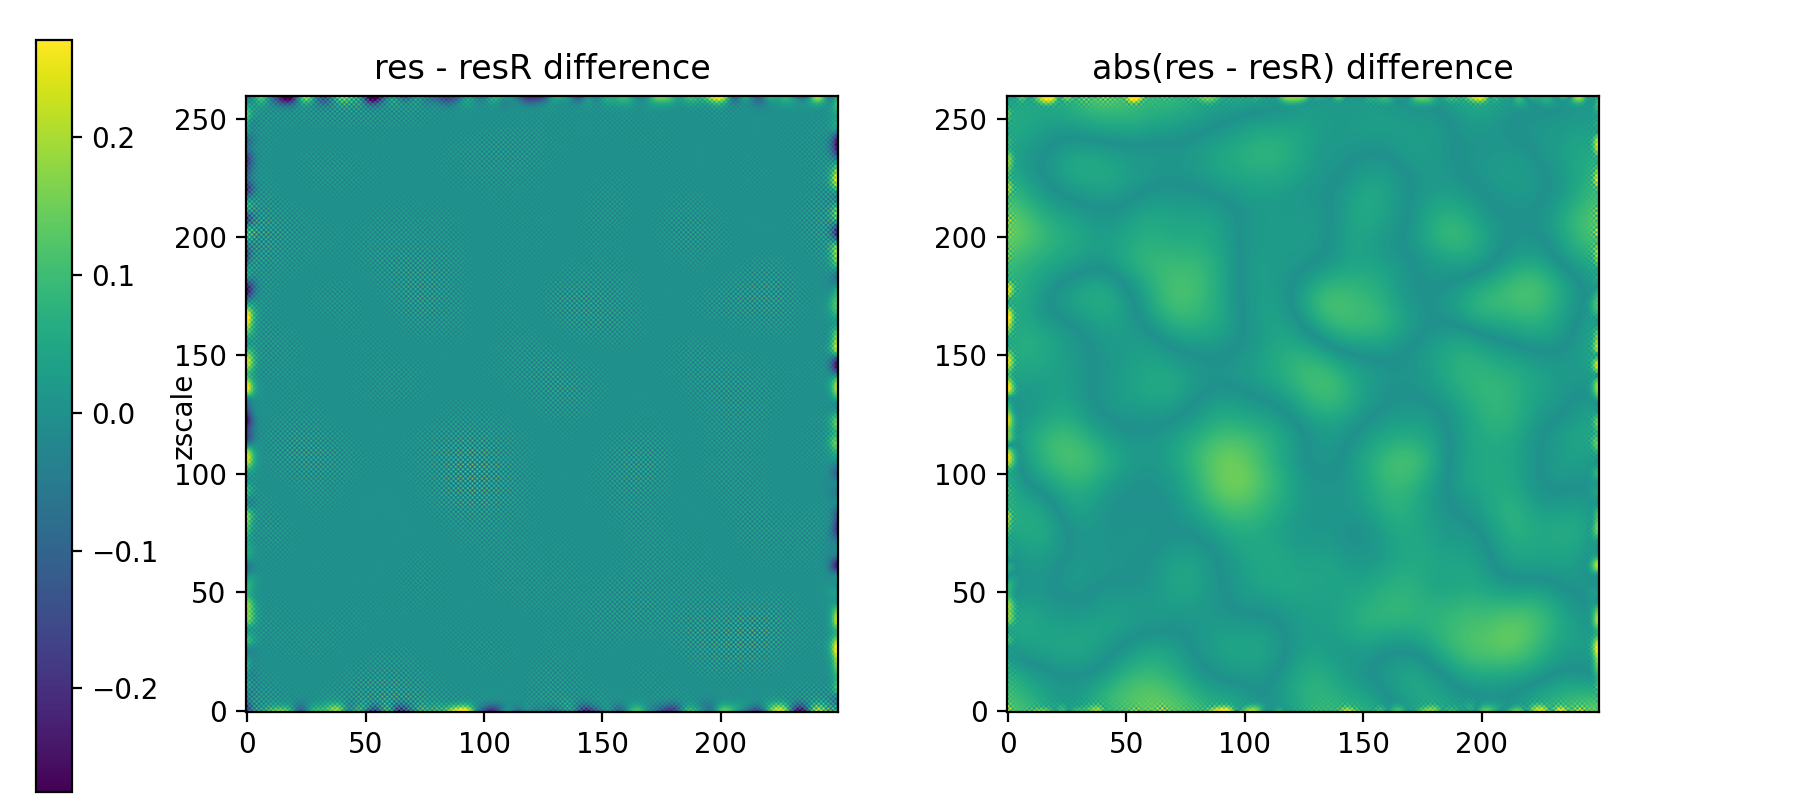

In [8]:
zscaler = ZScaleInterval()
D = R.res.image.array - R.resR.image.array
vmin, vmax = zscaler.get_limits(D)
# vmin, vman = None, None

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
cb = ax.imshow(D, origin='lower', vmin=vmin, vmax=vmax)
ax.set_title("res - resR difference")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.abs(D), origin='lower', vmin=vmin, vmax=vmax)
ax.set_title("abs(res - resR) difference")

ax = fig.add_axes((0.02,0.01,0.02,0.94))
fig.colorbar(cb, cax=ax, label='zscale')

In [9]:
# The metric is sometimes different indicating that a few pixel has changed sign
print(R.metric, R.metricR, abs(R.metric - R.metricR)*275)

-0.6 -0.6072727272727273 2.000000000000013


### Check the "science" input at the cutout positions
This is a test to see that we actually create the metric around sources.

<IPython.core.display.Javascript object>


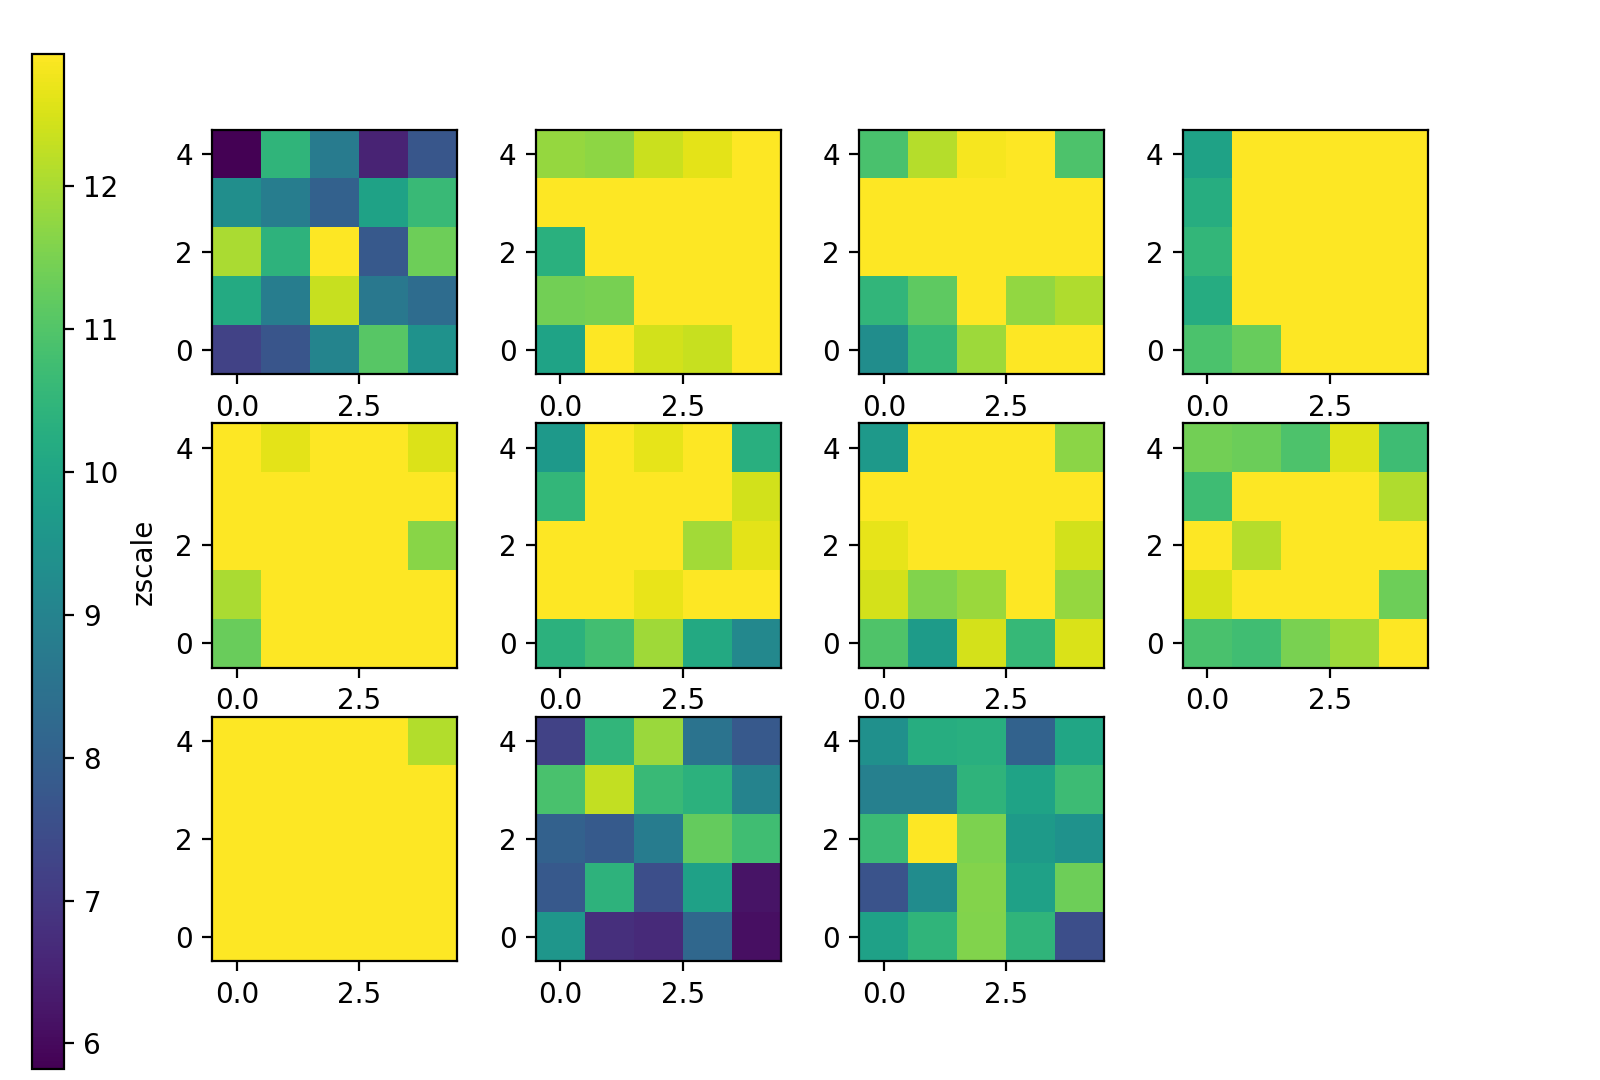

In [10]:
zscaler = ZScaleInterval()
vmin, vmax = zscaler.get_limits(R.cutsSCI[0])
axPerRow = 4
nRows = len(R.cutsSCI) // axPerRow + 1
fig1 = plt.figure(figsize=(8, nRows*1.8))

i_ax = 1
for S in R.cutsSCI:
    ax1 = fig1.add_subplot(nRows, axPerRow, i_ax)
    cb = ax1.imshow(S, origin='lower', interpolation='none', vmin=vmin, vmax=vmax)
    i_ax += 1
ax = fig1.add_axes((0.02,0.01,0.02,0.94))
fig1.colorbar(cb, cax=ax, label='zscale')

### Check the "reference" input at the cutout positions
This is a test to see that we actually create the metric around sources.

<IPython.core.display.Javascript object>


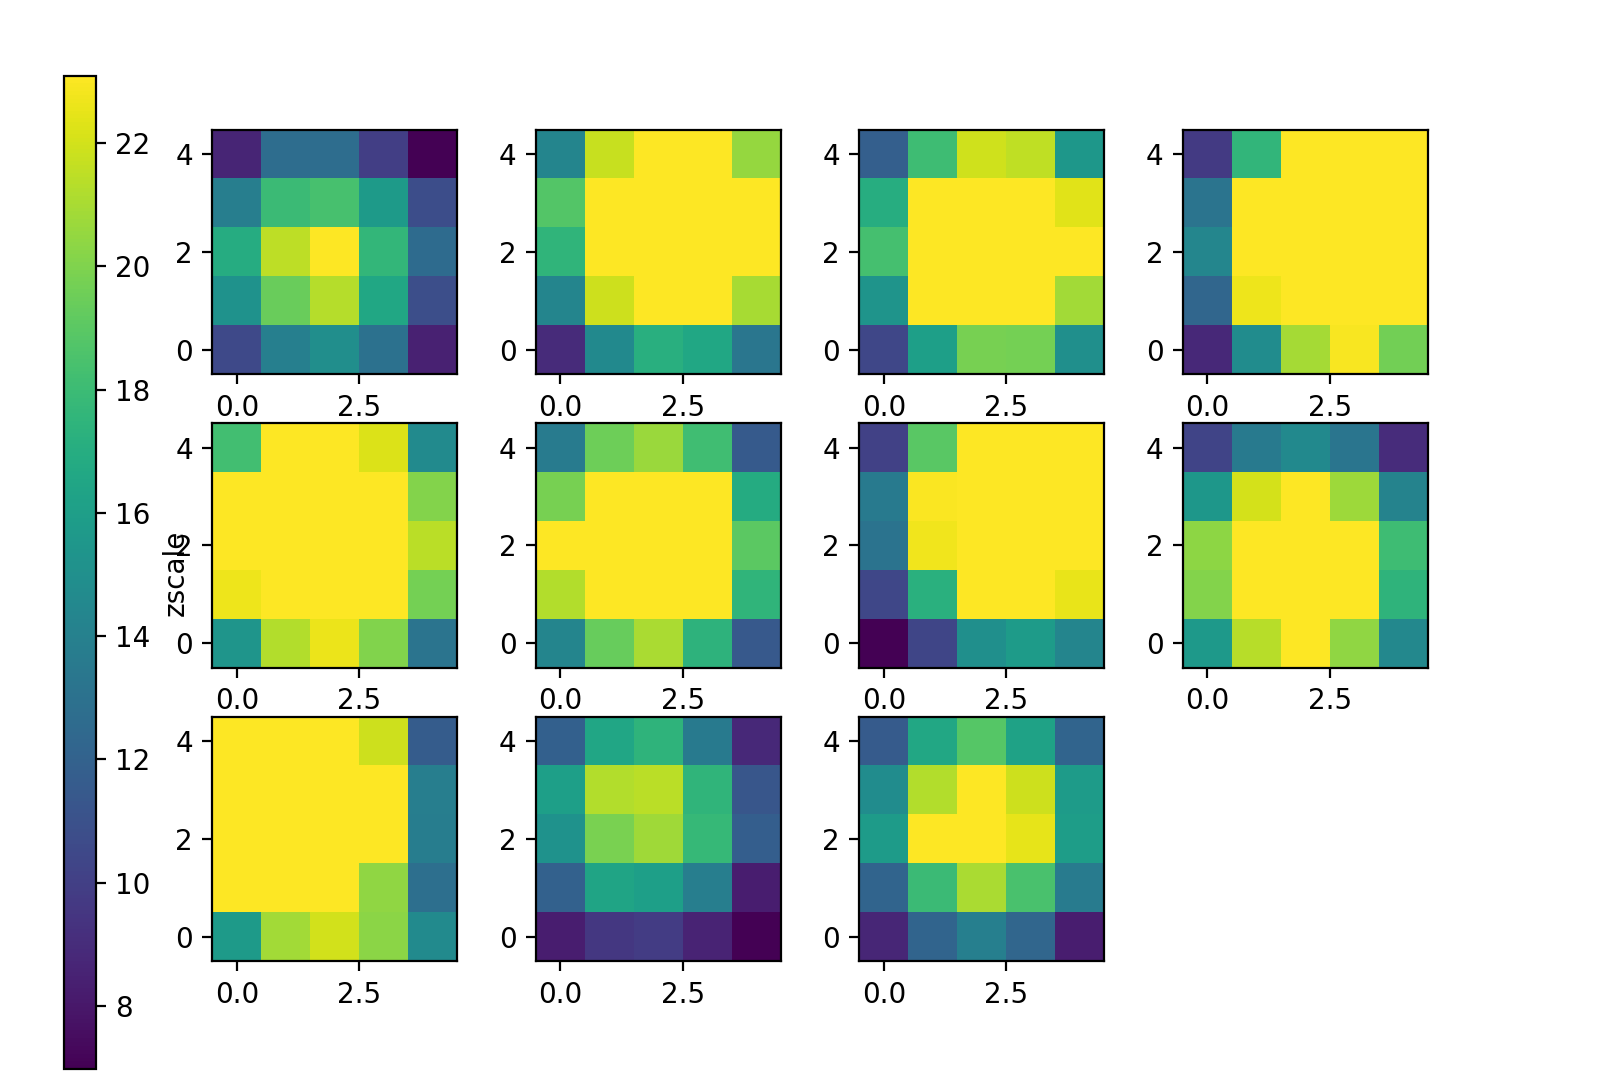

In [11]:
zscaler = ZScaleInterval()
vmin, vmax = zscaler.get_limits(R.cutsREF[0])
axPerRow = 4
nRows = len(R.cutsREF) // axPerRow + 1
fig1 = plt.figure(figsize=(8, nRows*1.8))

i_ax = 1
for S in R.cutsREF:
    ax1 = fig1.add_subplot(nRows, axPerRow, i_ax)
    cb = ax1.imshow(S, origin='lower', interpolation='none', vmin=vmin, vmax=vmax)
    i_ax += 1
ax = fig1.add_axes((0.04,0.01,0.02,0.92))
fig1.colorbar(cb, cax=ax, label='zscale')

### Check "residual1", "residual2", outputs and their difference "residual1 - residual2"

<IPython.core.display.Javascript object>


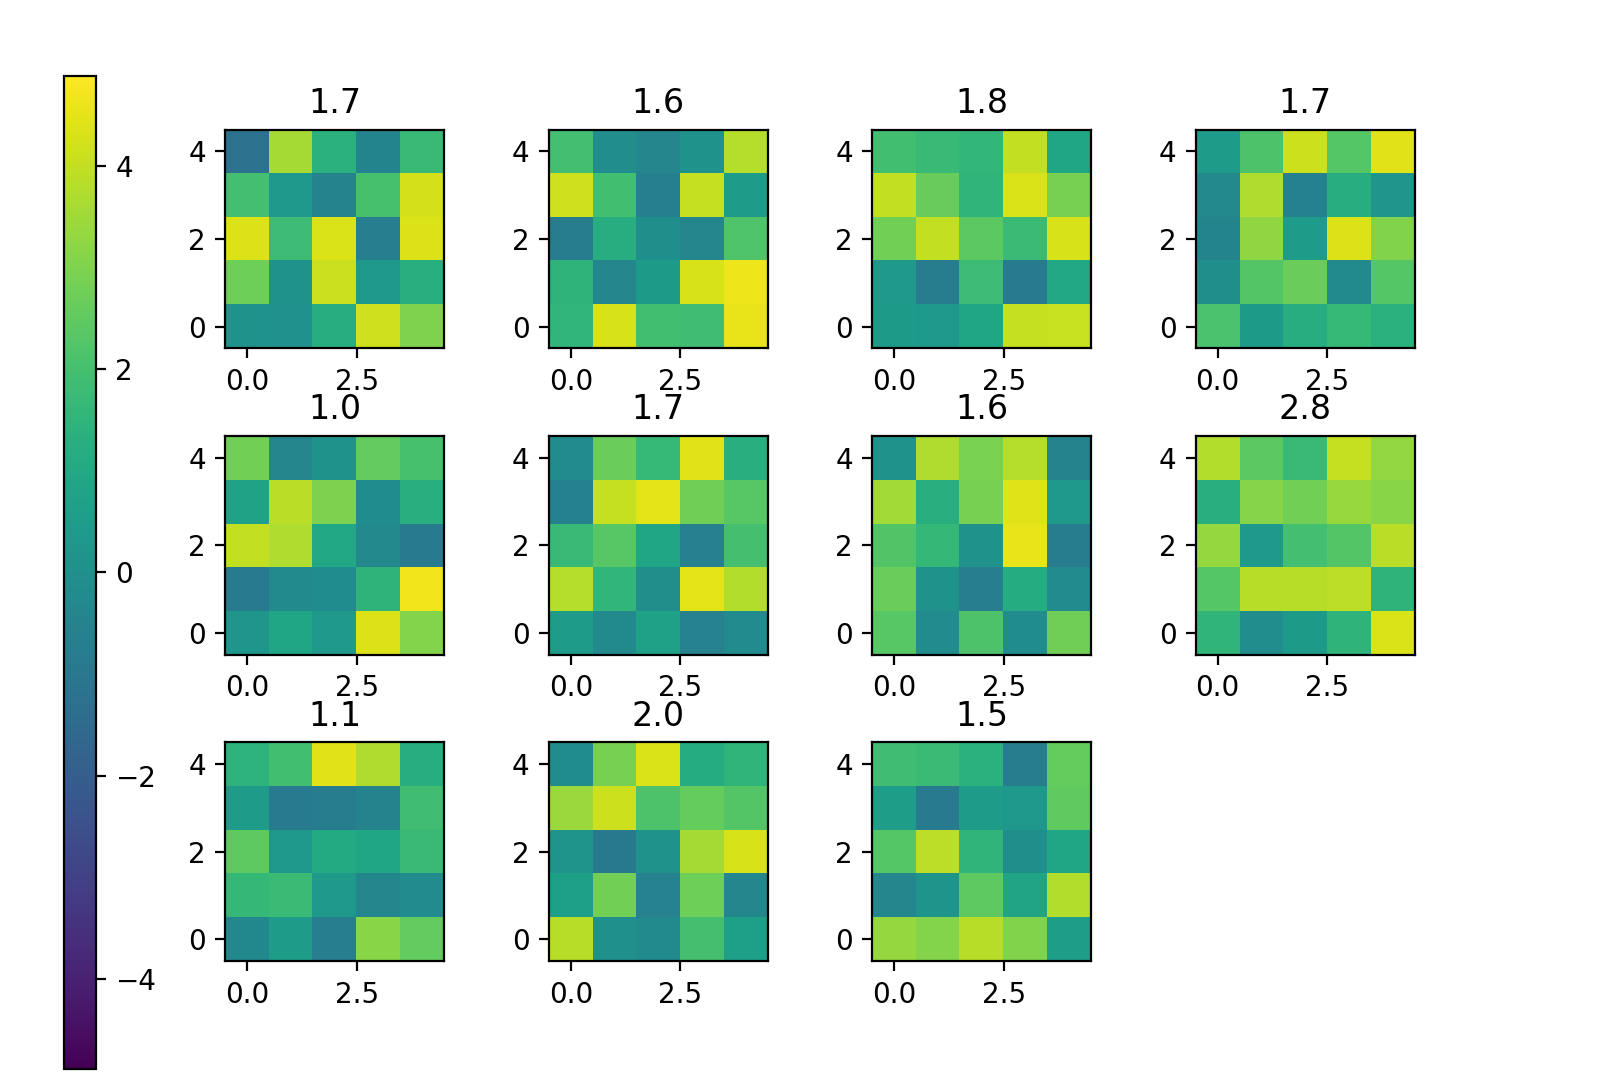

<IPython.core.display.Javascript object>


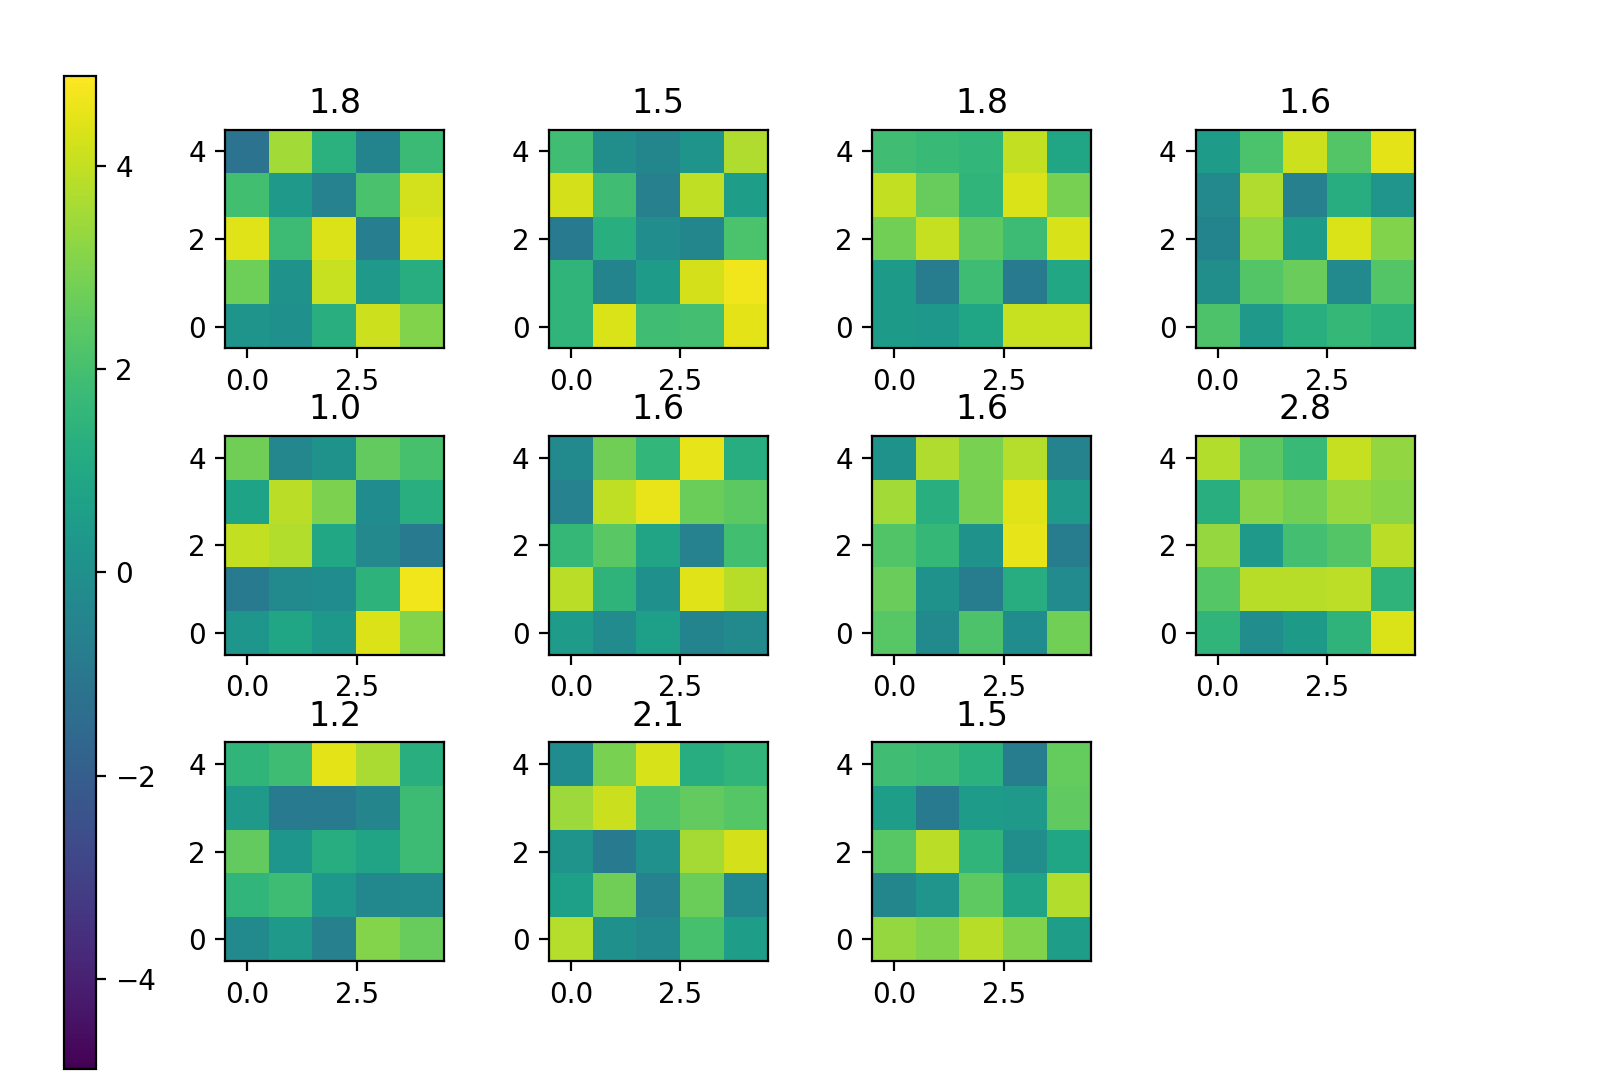

<IPython.core.display.Javascript object>


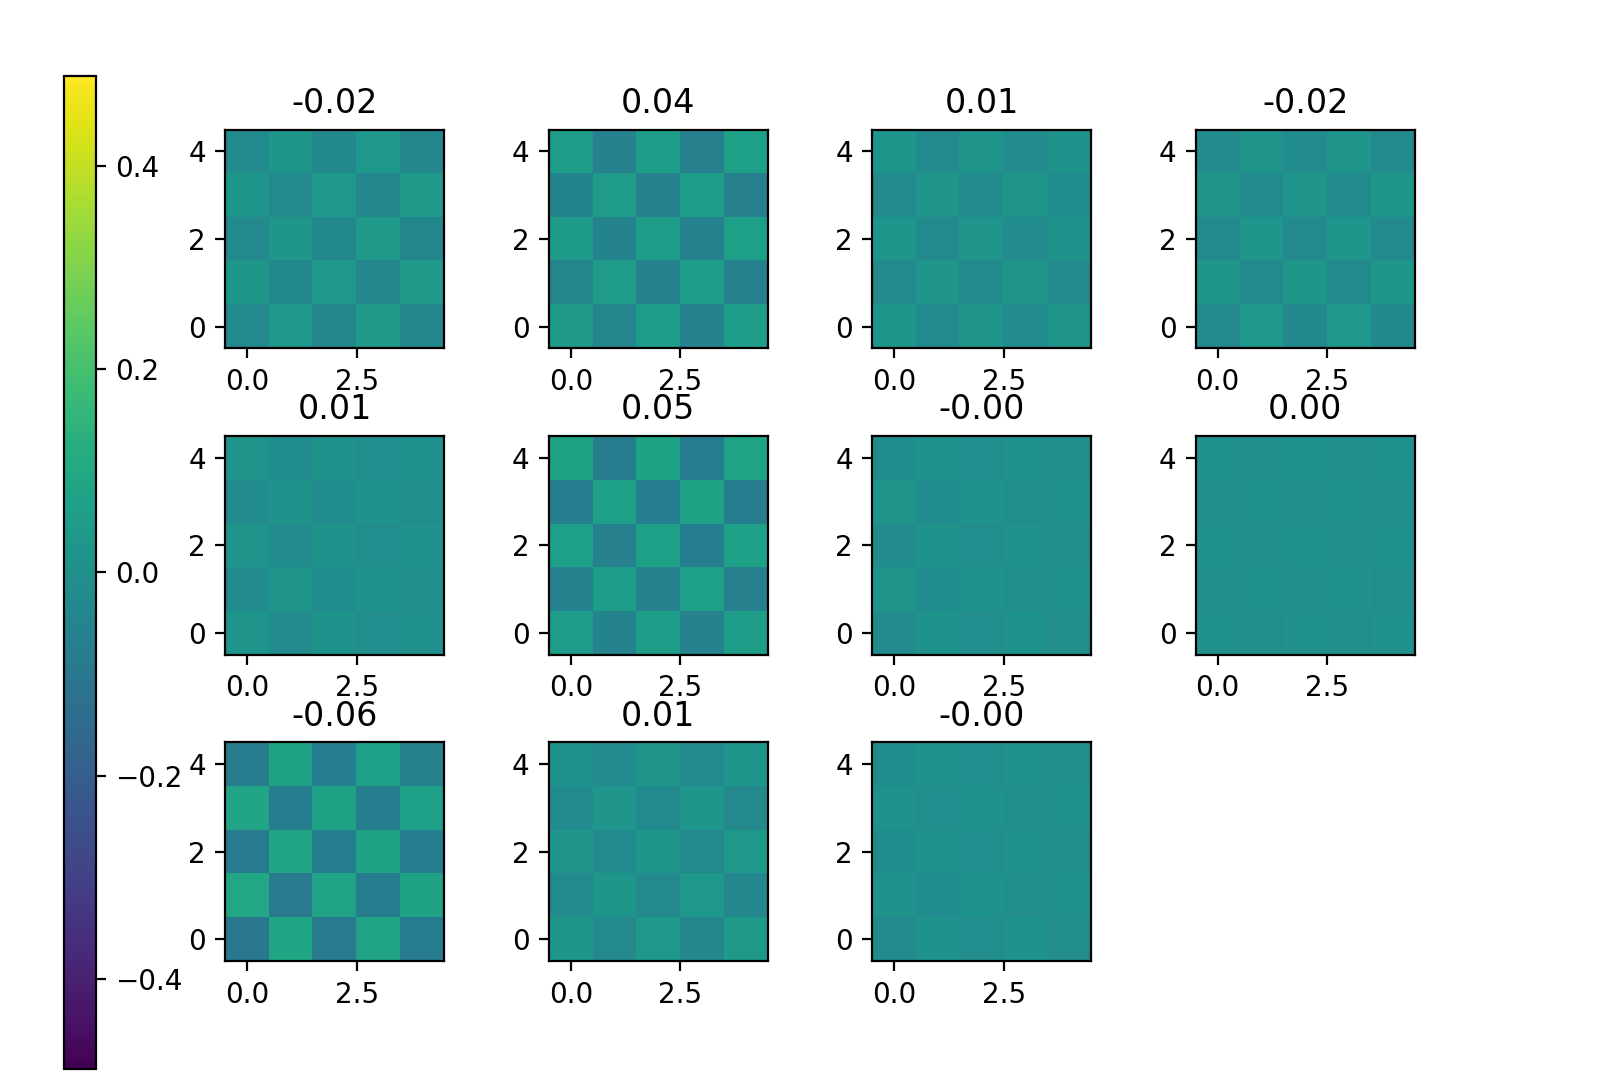

In [12]:
zscaler = ZScaleInterval()
vmin, vmax = zscaler.get_limits(R.res.image.array)
v = max(abs(vmin), abs(vmax))
axPerRow = 4
nRows = len(R.cuts) // axPerRow + 1
fig1 = plt.figure(figsize=(8, nRows*1.8))
fig2 = plt.figure(figsize=(8, nRows*1.8))
fig3 = plt.figure(figsize=(8, nRows*1.8))
fig1.subplots_adjust(hspace=0.4)
fig2.subplots_adjust(hspace=0.4)
fig3.subplots_adjust(hspace=0.4)

i_ax = 1
for A, B in zip(R.cuts, R.cutsR):
    ax1 = fig1.add_subplot(nRows, axPerRow, i_ax)
    ax2 = fig2.add_subplot(nRows, axPerRow, i_ax)
    ax3 = fig3.add_subplot(nRows, axPerRow, i_ax)
    cb1 = ax1.imshow(A, origin='lower', interpolation='none', vmin=-v, vmax=v)
    ax1.set_title(f"{np.median(A):.1f}")
    cb2 = ax2.imshow(B, origin='lower', interpolation='none',  vmin=-v, vmax=v)
    ax2.set_title(f"{np.median(B):.1f}")
    cb3 = ax3.imshow(A - B, origin='lower', interpolation='none',  vmin=-v*0.1, vmax=v*0.1)
    ax3.set_title(f"{np.median(A - B):.2f}")
    i_ax += 1
    
ax = fig1.add_axes((0.04,0.01,0.02,0.92))
fig1.colorbar(cb1, cax=ax)
ax = fig2.add_axes((0.04,0.01,0.02,0.92))
fig2.colorbar(cb2, cax=ax)
ax = fig3.add_axes((0.04,0.01,0.02,0.92))
fig3.colorbar(cb3, cax=ax)